# Streaming MT Prefix-Stability Project

이 프로젝트는 실시간 번역에서 prefix stability를 개선하는 것을 목표로 합니다.

## 1. 환경 설정

**사용 기술:**
- **Ollama**: 로컬 LLM 실행 환경 (가볍고 안정적)
- **LangChain**: LLM 프레임워크
- **GPU**: CUDA 지원 (선택사항, CPU도 가능)

In [22]:
# 필요한 패키지 설치
%pip install -q langchain langchain-ollama langchain-core langchain-community ollama

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. 모델 다운로드 및 LLM 초기화

아래 셀을 실행하여 Ollama 서버를 시작하고 모델을 다운로드합니다.

**참고:** GPU가 없거나 메모리가 부족한 경우, CPU 모드로 자동 전환됩니다.

In [ ]:
from langchain_ollama import ChatOllama

# 기본 설정
BASE_URL = "http://localhost:11434"
MODEL_NAME = "llama3.1:8b"

# LLM 인스턴스 생성 (서버와 모델은 다음 셀에서 자동 설정)
llm = ChatOllama(
    model=MODEL_NAME,
    temperature=0.0,
    base_url=BASE_URL
)

print(f"✓ LLM 인스턴스 생성 완료: {MODEL_NAME}")
print("📌 다음 셀을 실행하여 서버 시작 및 모델 다운로드를 진행하세요.")

✓ LLM 인스턴스 생성 완료: llama3.1:8b
📌 다음 셀을 실행하여 서버 시작 및 모델 다운로드를 진행하세요.


In [24]:
# 환경 감지 (Colab vs 로컬)
import platform

try:
    import google.colab
    is_colab = True
    print("🔵 Colab 환경 감지")
except:
    is_colab = False
    print("💻 로컬 환경 감지")

is_windows = platform.system() == 'Windows'
print(f"   운영체제: {platform.system()}")

💻 로컬 환경 감지
   운영체제: Windows


In [25]:
# Ollama 설치 + 서버 시작 + 모델 다운로드 (Windows & Colab 호환)
import subprocess, time, shutil, os, urllib.request

# ===== 1단계: Ollama 설치 =====
print("[1/4] Ollama 설치 확인...")

if is_colab:
    # Colab (Linux)
    !curl -fsSL https://ollama.com/install.sh | sh
    print("      ✅ Ollama 설치 완료 (Colab)")

elif shutil.which("ollama") is None:
    # Windows: 설치 안 되어 있으면 자동 다운로드 & 설치
    installer = os.path.join(os.environ['TEMP'], 'OllamaSetup.exe')
    url = "https://ollama.com/download/OllamaSetup.exe"
    print("      ⬇️  Ollama 다운로드 중... (약 100MB)")
    urllib.request.urlretrieve(url, installer)
    print("      📦 설치 중... (1~2분 소요, 창이 뜰 수 있습니다)")
    subprocess.run([installer, '/VERYSILENT', '/NORESTART'], check=True)
    # 설치 후 PATH 갱신
    ollama_path = os.path.join(os.environ['LOCALAPPDATA'], 'Programs', 'Ollama')
    os.environ['PATH'] = ollama_path + os.pathsep + os.environ['PATH']
    print("      ✅ Ollama 설치 완료")
else:
    print("      ✅ Ollama 이미 설치됨")

# ===== 2단계: 기존 Ollama 프로세스 완전 종료 =====
print("\n[2/4] 기존 Ollama 프로세스 종료 중...")
try:
    if is_windows:
        # 모든 Ollama 프로세스 강제 종료
        subprocess.run(['taskkill', '/F', '/IM', 'ollama.exe', '/T'], 
                      stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        subprocess.run(['taskkill', '/F', '/IM', 'ollama_llama_server.exe', '/T'], 
                      stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    else:
        subprocess.run(['pkill', '-9', 'ollama'], 
                      stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(3)
    print("      ✅ 기존 프로세스 종료 완료")
except:
    print("      ℹ️  실행 중인 프로세스 없음")

# ===== 3단계: GPU 모드로 서버 시작 =====
print("\n[3/4] Ollama 서버 시작 (GPU 모드)...")

# GPU 모드 환경 변수 설정
env = os.environ.copy()
# CUDA_VISIBLE_DEVICES와 OLLAMA_NUM_GPU를 설정하지 않으면 기본적으로 GPU 사용

if is_colab:
    !nohup ollama serve > ollama.log 2>&1 &
else:
    kwargs = {'creationflags': subprocess.CREATE_NO_WINDOW} if is_windows else {}
    subprocess.Popen(['ollama', 'serve'], 
                    stdout=subprocess.DEVNULL, 
                    stderr=subprocess.DEVNULL, 
                    env=env,
                    **kwargs)

print("      ⏳ 서버 초기화 대기 중 (10초)...")
time.sleep(10)

# 서버 연결 확인
for attempt in range(5):
    try:
        result = subprocess.run(['ollama', 'list'], 
                              capture_output=True, 
                              text=True, 
                              timeout=5)
        if result.returncode == 0:
            print("      ✅ 서버 시작 완료 (GPU 모드)")
            break
    except:
        pass
    if attempt < 4:
        print(f"      ⏳ 재시도 중... ({attempt + 1}/5)")
        time.sleep(3)
else:
    print("      ⚠️  서버 시작 확인 실패 - 수동으로 'ollama serve' 실행 필요")

# ===== 4단계: 모델 다운로드 =====
print(f"\n[4/4] 모델 다운로드: {MODEL_NAME}")
!ollama pull {MODEL_NAME}

# 연결 테스트
try:
    print("\n테스트 중...")
    response = llm.invoke("Say hello in one word.")
    print(f"🎉 설정 완료! 테스트 응답: {response.content}")
except Exception as e:
    print(f"\n⚠️ 오류 발생: {str(e)[:200]}")
    print("\n💡 해결 방법:")
    print("1. GPU 메모리가 부족한 경우, CPU 모드로 전환:")
    print("   - 새 PowerShell 창을 관리자 권한으로 열기")
    print("   - 다음 명령 입력:")
    print("     $env:CUDA_VISIBLE_DEVICES=''")
    print("     ollama serve")
    print("2. 또는 더 작은 모델 사용 (예: llama3.1:3b)")
    print("3. 위 터미널을 열어둔 채로 이 셀을 다시 실행")

[1/4] Ollama 설치 확인...
      ✅ Ollama 이미 설치됨

[2/4] 기존 Ollama 프로세스 종료 중...
      ✅ 기존 프로세스 종료 완료

[3/4] Ollama 서버 시작 (GPU 모드)...
      ⏳ 서버 초기화 대기 중 (10초)...
      ✅ 서버 시작 완료 (GPU 모드)

[4/4] 모델 다운로드: llama3.1:8b


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest 
pulling 667b0c1932bc: 100% ▕██████████████████▏ 4.9 GB                         
pulling 948af2743fc7: 100% ▕██████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4: 100% ▕██████████████████▏  12 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 455f34728c9b: 100% ▕██████████████████▏  487 B                         
verifying sha256 digest 
writing manifest 
success 



테스트 중...
🎉 설정 완료! 테스트 응답: Hello!


## 3. 실험: 발음 유사 오류 번역 비교

발음 유사 오류가 포함된 문장 번역 시, 3가지 방식을 비교합니다:
1. **Baseline**: 오류 교정 없이 바로 번역
2. **One-Stage**: 오류 교정과 번역을 한 번에 수행
3. **Two-Stage**: 오류 교정 후 번역 (단계 분리)

In [26]:
# 데이터 및 프롬프트 로드 (Colab & 로컬 환경 호환)
import os
from pathlib import Path

# Colab 환경 감지
try:
    import google.colab
    IS_COLAB = True
except:
    IS_COLAB = False

# 데이터 디렉토리 설정
if IS_COLAB:
    print("🔵 Colab 환경 감지")
    print("\n📂 데이터 파일 업로드 방법을 선택하세요:")
    print("1. Google Drive 마운트")
    print("2. 파일 직접 업로드")
    print("3. GitHub 클론")
    
    method = input("\n선택 (1/2/3): ").strip()
    
    if method == "1":
        # Google Drive 마운트
        from google.colab import drive
        drive.mount('/content/drive')
        
        # Drive 경로 입력 (예: /content/drive/MyDrive/Project)
        drive_path = input("Drive 내 프로젝트 폴더 경로 입력: ").strip()
        base_path = Path(drive_path)
        
    elif method == "2":
        # 파일 직접 업로드
        from google.colab import files
        import zipfile
        
        print("\n📤 프로젝트 폴더를 압축(zip)하여 업로드하세요")
        uploaded = files.upload()
        
        # 압축 해제
        for filename in uploaded.keys():
            if filename.endswith('.zip'):
                with zipfile.ZipFile(filename, 'r') as zip_ref:
                    zip_ref.extractall('/content/project')
                print(f"✓ {filename} 압축 해제 완료")
        
        base_path = Path('/content/project')
        
    else:  # method == "3"
        # GitHub 클론
        repo_url = input("\nGitHub 저장소 URL 입력: ").strip()
        !git clone {repo_url} /content/project
        base_path = Path('/content/project')
    
    data_dir = base_path / 'data'
    prompts_dir = base_path / 'prompts'
    results_dir = base_path / 'results'
    
else:
    print("💻 로컬 환경 감지")
    # 로컬 환경: 현재 디렉토리 기준
    base_path = Path('.')
    data_dir = base_path / 'data'
    prompts_dir = base_path / 'prompts'
    results_dir = base_path / 'results'

# results 디렉토리 생성 (없는 경우)
results_dir.mkdir(exist_ok=True)

# 데이터 및 프롬프트 로드
print(f"\n📂 데이터 로드 중...")
with open(data_dir / 'clean_sentences.txt', 'r', encoding='utf-8') as f:
    clean_sentences = [line.strip() for line in f if line.strip()]
with open(data_dir / 'noisy_sentences.txt', 'r', encoding='utf-8') as f:
    noisy_sentences = [line.strip() for line in f if line.strip()]
with open(data_dir / 'answer_sentences.txt', 'r', encoding='utf-8') as f:
    answer_sentences = [line.strip() for line in f if line.strip()]
with open(prompts_dir / 'baseline.txt', 'r', encoding='utf-8') as f:
    baseline_prompt = f.read().strip()
with open(prompts_dir / 'phonetic_aware.txt', 'r', encoding='utf-8') as f:
    phonetic_aware_prompt = f.read().strip()
with open(prompts_dir / 'correction.txt', 'r', encoding='utf-8') as f:
    correction_prompt = f.read().strip()

print(f"✓ 데이터 로드 완료: {len(clean_sentences)}개 문장")
print(f"✓ 정답 번역 로드 완료: {len(answer_sentences)}개")
print(f"✓ 프롬프트 로드 완료")
print(f"✓ 결과 저장 경로: {results_dir}")

💻 로컬 환경 감지

📂 데이터 로드 중...
✓ 데이터 로드 완료: 27개 문장
✓ 정답 번역 로드 완료: 27개
✓ 프롬프트 로드 완료
✓ 결과 저장 경로: results


In [27]:
# 번역 체인 생성
from langchain_core.prompts import ChatPromptTemplate

# Baseline: 오류 교정 없이 번역
baseline_chain = ChatPromptTemplate.from_messages([
    ("system", baseline_prompt), ("human", "{text}")
]) | llm

# One-Stage: 오류 교정 + 번역 동시
onestage_chain = ChatPromptTemplate.from_messages([
    ("system", phonetic_aware_prompt), ("human", "{text}")
]) | llm

# Two-Stage용: 오류 교정만 수행 (번역 X)
correction_chain = ChatPromptTemplate.from_messages([
    ("system", correction_prompt), ("human", "{text}")
]) | llm

print("✓ 번역 체인 생성 완료")

✓ 번역 체인 생성 완료


## 4. 실험 실행

각 방식을 개별적으로 실행하여 결과를 비교합니다.

### 방식 1: Baseline (오류 교정 없이 바로 번역)

In [28]:
# Baseline 방식: 오류 교정 없이 바로 번역
import time
import pandas as pd

baseline_results = []

print("=" * 80)
print("방식 1: Baseline (오류 교정 없음)")
print("=" * 80)

for idx, (clean, noisy) in enumerate(zip(clean_sentences, noisy_sentences), 1):
    print(f"\n[케이스 {idx}/{len(clean_sentences)}]")
    print(f"원본(Clean):  {clean}")
    print(f"오류(Noisy):  {noisy}")
    
    baseline_trans = baseline_chain.invoke({"text": noisy}).content
    time.sleep(0.3)
    
    print(f"번역 결과:    {baseline_trans}")
    
    baseline_results.append({
        'index': idx,
        'clean': clean,
        'noisy': noisy,
        'translation': baseline_trans
    })

print(f"\n✓ Baseline 실험 완료: {len(baseline_results)}개 케이스")

# 결과를 DataFrame으로 표시
df_baseline = pd.DataFrame(baseline_results)
print("\n📊 Baseline 결과 요약:")
df_baseline

방식 1: Baseline (오류 교정 없음)

[케이스 1/27]
원본(Clean):  오늘 온라인으로 결제했습니다.
오류(Noisy):  ﻿오늘 온라인으로 결재했습니다.
번역 결과:    I paid online today.

[케이스 2/27]
원본(Clean):  매일 아침 운동을 합니다.
오류(Noisy):  메일 아침 운동을 합니다.
번역 결과:    I do morning exercise by mail.

[케이스 3/27]
원본(Clean):  모래는 토요일입니다.
오류(Noisy):  모레는 토요일입니다.
번역 결과:    Tomorrow is Saturday.

[케이스 4/27]
원본(Clean):  베개를 새로 샀어요.
오류(Noisy):  배개를 새로 샀어요.
번역 결과:    I bought a new hat.

[케이스 5/27]
원본(Clean):  감기에 걸렸어요.
오류(Noisy):  강기에 걸렸어요.
번역 결과:    I caught a cold.

[케이스 6/27]
원본(Clean):  낫으로 풀을 베었습니다.
오류(Noisy):  낮으로 풀을 베었습니다.
번역 결과:    I mowed the lawn low.

[케이스 7/27]
원본(Clean):  성함이 어떻게 되세요?
오류(Noisy):  선함이 어떻게 되세요?
번역 결과:    How's your day going?

[케이스 8/27]
원본(Clean):  수박을 먹었습니다.
오류(Noisy):  숙박을 먹었습니다.
번역 결과:    Stayed and ate.

[케이스 9/27]
원본(Clean):  밤샘 작업을 했어요.
오류(Noisy):  방생 작업을 했어요.
번역 결과:    I had a birth plan.

[케이스 10/27]
원본(Clean):  안개가 끼었네요.
오류(Noisy):  안게가 끼었네요.
번역 결과:    It's getting cold.

[케이스 11/27]
원본(Clean):  과일을 사다 주세요.
오류(Noisy):  과

,index,clean,noisy,translation
0,1,오늘 온라인으로 결제했습니다.,﻿오늘 온라인으로 결재했습니다.,I paid online today.
1,2,매일 아침 운동을 합니다.,메일 아침 운동을 합니다.,I do morning exercise by mail.
2,3,모래는 토요일입니다.,모레는 토요일입니다.,Tomorrow is Saturday.
3,4,베개를 새로 샀어요.,배개를 새로 샀어요.,I bought a new hat.
4,5,감기에 걸렸어요.,강기에 걸렸어요.,I caught a cold.
5,6,낫으로 풀을 베었습니다.,낮으로 풀을 베었습니다.,I mowed the lawn low.
6,7,성함이 어떻게 되세요?,선함이 어떻게 되세요?,How's your day going?
7,8,수박을 먹었습니다.,숙박을 먹었습니다.,Stayed and ate.
8,9,밤샘 작업을 했어요.,방생 작업을 했어요.,I had a birth plan.
9,10,안개가 끼었네요.,안게가 끼었네요.,It's getting cold.


### 방식 2: One-Stage (오류 교정 + 번역 동시 수행)

In [29]:
# One-Stage 방식: 오류 교정과 번역을 한 번에 수행
import time
import pandas as pd

onestage_results = []

print("=" * 80)
print("방식 2: One-Stage (교정 + 번역 동시)")
print("=" * 80)

for idx, (clean, noisy) in enumerate(zip(clean_sentences, noisy_sentences), 1):
    print(f"\n[케이스 {idx}/{len(clean_sentences)}]")
    print(f"원본(Clean):  {clean}")
    print(f"오류(Noisy):  {noisy}")
    
    onestage_trans = onestage_chain.invoke({"text": noisy}).content
    time.sleep(0.3)
    
    print(f"번역 결과:    {onestage_trans}")
    
    onestage_results.append({
        'index': idx,
        'clean': clean,
        'noisy': noisy,
        'translation': onestage_trans
    })

print(f"\n✓ One-Stage 실험 완료: {len(onestage_results)}개 케이스")

# 결과를 DataFrame으로 표시
df_onestage = pd.DataFrame(onestage_results)
print("\n📊 One-Stage 결과 요약:")
df_onestage

방식 2: One-Stage (교정 + 번역 동시)

[케이스 1/27]
원본(Clean):  오늘 온라인으로 결제했습니다.
오류(Noisy):  ﻿오늘 온라인으로 결재했습니다.
번역 결과:    I paid online today.

[케이스 2/27]
원본(Clean):  매일 아침 운동을 합니다.
오류(Noisy):  메일 아침 운동을 합니다.
번역 결과:    I do my morning exercise by mail.

[케이스 3/27]
원본(Clean):  모래는 토요일입니다.
오류(Noisy):  모레는 토요일입니다.
번역 결과:    Tomorrow is Saturday.

[케이스 4/27]
원본(Clean):  베개를 새로 샀어요.
오류(Noisy):  배개를 새로 샀어요.
번역 결과:    I bought a new birdcage.

[케이스 5/27]
원본(Clean):  감기에 걸렸어요.
오류(Noisy):  강기에 걸렸어요.
번역 결과:    I caught a cold.

[케이스 6/27]
원본(Clean):  낫으로 풀을 베었습니다.
오류(Noisy):  낮으로 풀을 베었습니다.
번역 결과:    I mowed the lawn low.

[케이스 7/27]
원본(Clean):  성함이 어떻게 되세요?
오류(Noisy):  선함이 어떻게 되세요?
번역 결과:    How's your mood today?

[케이스 8/27]
원본(Clean):  수박을 먹었습니다.
오류(Noisy):  숙박을 먹었습니다.
번역 결과:    I stayed and ate.

[케이스 9/27]
원본(Clean):  밤샘 작업을 했어요.
오류(Noisy):  방생 작업을 했어요.
번역 결과:    I had a birth plan.

[케이스 10/27]
원본(Clean):  안개가 끼었네요.
오류(Noisy):  안게가 끼었네요.
번역 결과:    I got stuck in traffic.

[케이스 11/27]
원본(Clean):  과일을 사다

,index,clean,noisy,translation
0,1,오늘 온라인으로 결제했습니다.,﻿오늘 온라인으로 결재했습니다.,I paid online today.
1,2,매일 아침 운동을 합니다.,메일 아침 운동을 합니다.,I do my morning exercise by mail.
2,3,모래는 토요일입니다.,모레는 토요일입니다.,Tomorrow is Saturday.
3,4,베개를 새로 샀어요.,배개를 새로 샀어요.,I bought a new birdcage.
4,5,감기에 걸렸어요.,강기에 걸렸어요.,I caught a cold.
5,6,낫으로 풀을 베었습니다.,낮으로 풀을 베었습니다.,I mowed the lawn low.
6,7,성함이 어떻게 되세요?,선함이 어떻게 되세요?,How's your mood today?
7,8,수박을 먹었습니다.,숙박을 먹었습니다.,I stayed and ate.
8,9,밤샘 작업을 했어요.,방생 작업을 했어요.,I had a birth plan.
9,10,안개가 끼었네요.,안게가 끼었네요.,I got stuck in traffic.


### 방식 3: Two-Stage (오류 교정 후 번역, 단계 분리)

In [30]:
# Two-Stage 방식: 오류 교정 후 번역 (단계 분리)
import time
import pandas as pd

twostage_results = []

print("=" * 80)
print("방식 3: Two-Stage (교정 → 번역, 단계 분리)")
print("=" * 80)

for idx, (clean, noisy) in enumerate(zip(clean_sentences, noisy_sentences), 1):
    print(f"\n[케이스 {idx}/{len(clean_sentences)}]")
    print(f"원본(Clean):  {clean}")
    print(f"오류(Noisy):  {noisy}")
    
    # 1단계: 오류 교정
    corrected = correction_chain.invoke({"text": noisy}).content
    time.sleep(0.3)
    print(f"교정 결과:    {corrected}")
    
    # 2단계: 번역
    twostage_trans = baseline_chain.invoke({"text": corrected}).content
    time.sleep(0.3)
    print(f"번역 결과:    {twostage_trans}")
    
    # 교정 성공 여부 표시
    if noisy != corrected:
        print(f"  ✓ 오류 교정됨")
    else:
        print(f"  - 교정 변화 없음")
    
    twostage_results.append({
        'index': idx,
        'clean': clean,
        'noisy': noisy,
        'corrected': corrected,
        'translation': twostage_trans
    })

print(f"\n✓ Two-Stage 실험 완료: {len(twostage_results)}개 케이스")

# 결과를 DataFrame으로 표시
df_twostage = pd.DataFrame(twostage_results)
print("\n📊 Two-Stage 결과 요약:")
df_twostage

방식 3: Two-Stage (교정 → 번역, 단계 분리)

[케이스 1/27]
원본(Clean):  오늘 온라인으로 결제했습니다.
오류(Noisy):  ﻿오늘 온라인으로 결재했습니다.
교정 결과:    오늘 온라인으로 결제했습니다.
번역 결과:    I made an online payment today.
  ✓ 오류 교정됨

[케이스 2/27]
원본(Clean):  매일 아침 운동을 합니다.
오류(Noisy):  메일 아침 운동을 합니다.
교정 결과:    매일 아침 운동을 합니다.
번역 결과:    I exercise every morning.
  ✓ 오류 교정됨

[케이스 3/27]
원본(Clean):  모래는 토요일입니다.
오류(Noisy):  모레는 토요일입니다.
교정 결과:    내일은 토요일입니다.
번역 결과:    Tomorrow is Saturday.
  ✓ 오류 교정됨

[케이스 4/27]
원본(Clean):  베개를 새로 샀어요.
오류(Noisy):  배개를 새로 샀어요.
교정 결과:    배지를 새로 샀어요.
번역 결과:    I just bought a flag.
  ✓ 오류 교정됨

[케이스 5/27]
원본(Clean):  감기에 걸렸어요.
오류(Noisy):  강기에 걸렸어요.
교정 결과:    감기였어요.
번역 결과:    I had a cold.
  ✓ 오류 교정됨

[케이스 6/27]
원본(Clean):  낫으로 풀을 베었습니다.
오류(Noisy):  낮으로 풀을 베었습니다.
교정 결과:    낮에 풀을 베었습니다.
번역 결과:    I pulled out weeds in the daytime.
  ✓ 오류 교정됨

[케이스 7/27]
원본(Clean):  성함이 어떻게 되세요?
오류(Noisy):  선함이 어떻게 되세요?
교정 결과:    선생님의 건강은 어떻세요?
번역 결과:    How is your teacher's health?
  ✓ 오류 교정됨

[케이스 8/27]
원본(Clean):  수박을 먹었습니다.
오류(N

,index,clean,noisy,corrected,translation
0,1,오늘 온라인으로 결제했습니다.,﻿오늘 온라인으로 결재했습니다.,오늘 온라인으로 결제했습니다.,I made an online payment today.
1,2,매일 아침 운동을 합니다.,메일 아침 운동을 합니다.,매일 아침 운동을 합니다.,I exercise every morning.
2,3,모래는 토요일입니다.,모레는 토요일입니다.,내일은 토요일입니다.,Tomorrow is Saturday.
3,4,베개를 새로 샀어요.,배개를 새로 샀어요.,배지를 새로 샀어요.,I just bought a flag.
4,5,감기에 걸렸어요.,강기에 걸렸어요.,감기였어요.,I had a cold.
5,6,낫으로 풀을 베었습니다.,낮으로 풀을 베었습니다.,낮에 풀을 베었습니다.,I pulled out weeds in the daytime.
6,7,성함이 어떻게 되세요?,선함이 어떻게 되세요?,선생님의 건강은 어떻세요?,How is your teacher's health?
7,8,수박을 먹었습니다.,숙박을 먹었습니다.,숙소에서 식사를했습니다.,I had a meal at my accommodation.
8,9,밤샘 작업을 했어요.,방생 작업을 했어요.,방생작업을 했어요.,I had a birth plan.
9,10,안개가 끼었네요.,안게가 끼었네요.,안개가 끼었습니다.,The fog has come down.


## 5. 3가지 방식 비교 분석

In [31]:
# 3가지 방식 비교 분석
import pandas as pd
import json
from datetime import datetime

print("=" * 80)
print("3가지 방식 비교 분석")
print("=" * 80)

# 모든 결과 통합
comparison_results = []

for i in range(len(clean_sentences)):
    result = {
        'index': i + 1,
        'clean': clean_sentences[i],
        'noisy': noisy_sentences[i],
        'baseline': baseline_results[i]['translation'],
        'onestage': onestage_results[i]['translation'],
        'corrected': twostage_results[i]['corrected'],
        'twostage': twostage_results[i]['translation']
    }
    comparison_results.append(result)
    
    print(f"\n[케이스 {result['index']}]")
    print(f"원본(Clean):   {result['clean']}")
    print(f"오류(Noisy):   {result['noisy']}")
    print(f"Baseline:      {result['baseline']}")
    print(f"One-Stage:     {result['onestage']}")
    print(f"Two-Stage:     {result['corrected']} → {result['twostage']}")
    
    # 번역 결과 다양성 분석
    translations = [result['baseline'].lower(), result['onestage'].lower(), result['twostage'].lower()]
    unique_count = len(set(translations))
    
    if unique_count == 1:
        print(f"  → ✓ 3가지 방식 모두 동일한 번역")
    elif unique_count == 2:
        print(f"  → ⚠️ 일부 방식이 다른 번역")
    else:
        print(f"  → ❌ 3가지 방식 모두 다른 번역")

# 결과를 DataFrame으로 정리
df_comparison = pd.DataFrame(comparison_results)

print("\n" + "=" * 80)
print("📊 전체 결과 DataFrame")
print("=" * 80)
print(df_comparison)

# 결과 저장
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = results_dir / f"experiment_{timestamp}.json"

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(comparison_results, f, ensure_ascii=False, indent=2)

print(f"\n✓ 결과 저장: {output_file}")

# Colab 환경인 경우 다운로드 옵션 제공
if IS_COLAB:
    print("\n📥 결과 파일을 다운로드하시겠습니까? (y/n)")
    if input().strip().lower() == 'y':
        from google.colab import files
        files.download(str(output_file))
        print("✓ 다운로드 완료")

3가지 방식 비교 분석

[케이스 1]
원본(Clean):   오늘 온라인으로 결제했습니다.
오류(Noisy):   ﻿오늘 온라인으로 결재했습니다.
Baseline:      I paid online today.
One-Stage:     I paid online today.
Two-Stage:     오늘 온라인으로 결제했습니다. → I made an online payment today.
  → ⚠️ 일부 방식이 다른 번역

[케이스 2]
원본(Clean):   매일 아침 운동을 합니다.
오류(Noisy):   메일 아침 운동을 합니다.
Baseline:      I do morning exercise by mail.
One-Stage:     I do my morning exercise by mail.
Two-Stage:     매일 아침 운동을 합니다. → I exercise every morning.
  → ❌ 3가지 방식 모두 다른 번역

[케이스 3]
원본(Clean):   모래는 토요일입니다.
오류(Noisy):   모레는 토요일입니다.
Baseline:      Tomorrow is Saturday.
One-Stage:     Tomorrow is Saturday.
Two-Stage:     내일은 토요일입니다. → Tomorrow is Saturday.
  → ✓ 3가지 방식 모두 동일한 번역

[케이스 4]
원본(Clean):   베개를 새로 샀어요.
오류(Noisy):   배개를 새로 샀어요.
Baseline:      I bought a new hat.
One-Stage:     I bought a new birdcage.
Two-Stage:     배지를 새로 샀어요. → I just bought a flag.
  → ❌ 3가지 방식 모두 다른 번역

[케이스 5]
원본(Clean):   감기에 걸렸어요.
오류(Noisy):   강기에 걸렸어요.
Baseline:      I caught a cold.
One-Stage:     I c

## 6. 결론

### 3가지 방식 비교

1. **Baseline** - 오류를 그대로 번역 → 잘못된 결과 가능
2. **One-Stage** - 교정+번역 동시 → 불안정 (지시사항 준수 어려움)
3. **Two-Stage** - 교정 후 번역 → 안정적 (단계 분리로 성공률 향상)

### 핵심 인사이트

- LLM에게 복잡한 작업을 동시에 시키면 실패율 증가
- 단순한 단계로 분리하면 성공률 향상
- Trade-off: 안정성(Two-Stage) vs 효율성(One-Stage, 호출 1회)

### 정량적 평가 (BLEU Score)

다음 섹션에서 정답 번역과의 비교를 통해 각 방법의 성능을 정량적으로 평가합니다.

## 7. 번역 품질 평가

In [32]:
# 평가 지표 계산을 위한 패키지 설치
%pip install -q sacrebleu matplotlib nltk

# METEOR를 위한 NLTK 데이터 다운로드
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("✓ 패키지 설치 완료")

Note: you may need to restart the kernel to use updated packages.
✓ 패키지 설치 완료



[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# 번역 품질 평가 - BLEU & METEOR Score 계산
import sacrebleu
import numpy as np
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

print("=" * 80)
print("번역 품질 평가 (BLEU & METEOR Score)")
print("=" * 80)

# 각 방법별 BLEU & METEOR score 계산
baseline_bleu_scores = []
onestage_bleu_scores = []
twostage_bleu_scores = []

baseline_meteor_scores = []
onestage_meteor_scores = []
twostage_meteor_scores = []

for i in range(len(answer_sentences)):
    reference = answer_sentences[i]
    reference_tokens = word_tokenize(reference.lower())
    
    # Baseline BLEU & METEOR
    baseline_translation = baseline_results[i]['translation']
    baseline_bleu = sacrebleu.sentence_bleu(baseline_translation, [reference]).score
    baseline_bleu_scores.append(baseline_bleu)
    baseline_meteor = meteor_score([reference_tokens], word_tokenize(baseline_translation.lower())) * 100
    baseline_meteor_scores.append(baseline_meteor)
    
    # One-Stage BLEU & METEOR
    onestage_translation = onestage_results[i]['translation']
    onestage_bleu = sacrebleu.sentence_bleu(onestage_translation, [reference]).score
    onestage_bleu_scores.append(onestage_bleu)
    onestage_meteor = meteor_score([reference_tokens], word_tokenize(onestage_translation.lower())) * 100
    onestage_meteor_scores.append(onestage_meteor)
    
    # Two-Stage BLEU & METEOR
    twostage_translation = twostage_results[i]['translation']
    twostage_bleu = sacrebleu.sentence_bleu(twostage_translation, [reference]).score
    twostage_bleu_scores.append(twostage_bleu)
    twostage_meteor = meteor_score([reference_tokens], word_tokenize(twostage_translation.lower())) * 100
    twostage_meteor_scores.append(twostage_meteor)
    
    print(f"\n[케이스 {i+1}]")
    print(f"정답:     {reference}")
    print(f"Baseline: {baseline_translation}")
    print(f"          BLEU: {baseline_bleu:.2f} | METEOR: {baseline_meteor:.2f}")
    print(f"One-Stage: {onestage_translation}")
    print(f"          BLEU: {onestage_bleu:.2f} | METEOR: {onestage_meteor:.2f}")
    print(f"Two-Stage: {twostage_translation}")
    print(f"          BLEU: {twostage_bleu:.2f} | METEOR: {twostage_meteor:.2f}")

# 평균 BLEU & METEOR score 계산
avg_baseline_bleu = np.mean(baseline_bleu_scores)
avg_onestage_bleu = np.mean(onestage_bleu_scores)
avg_twostage_bleu = np.mean(twostage_bleu_scores)

avg_baseline_meteor = np.mean(baseline_meteor_scores)
avg_onestage_meteor = np.mean(onestage_meteor_scores)
avg_twostage_meteor = np.mean(twostage_meteor_scores)

print("\n" + "=" * 80)
print("평균 BLEU Score")
print("=" * 80)
print(f"Baseline:  {avg_baseline_bleu:.2f}")
print(f"One-Stage: {avg_onestage_bleu:.2f}")
print(f"Two-Stage: {avg_twostage_bleu:.2f}")

print("\n" + "=" * 80)
print("평균 METEOR Score")
print("=" * 80)
print(f"Baseline:  {avg_baseline_meteor:.2f}")
print(f"One-Stage: {avg_onestage_meteor:.2f}")
print(f"Two-Stage: {avg_twostage_meteor:.2f}")

# Exact Match 계산
baseline_exact_matches = sum(1 for i in range(len(answer_sentences)) 
                             if baseline_results[i]['translation'].lower() == answer_sentences[i].lower())
onestage_exact_matches = sum(1 for i in range(len(answer_sentences)) 
                             if onestage_results[i]['translation'].lower() == answer_sentences[i].lower())
twostage_exact_matches = sum(1 for i in range(len(answer_sentences)) 
                             if twostage_results[i]['translation'].lower() == answer_sentences[i].lower())

print("\n" + "=" * 80)
print("Exact Match (정확히 일치)")
print("=" * 80)
print(f"Baseline:  {baseline_exact_matches}/{len(answer_sentences)} ({baseline_exact_matches/len(answer_sentences)*100:.1f}%)")
print(f"One-Stage: {onestage_exact_matches}/{len(answer_sentences)} ({onestage_exact_matches/len(answer_sentences)*100:.1f}%)")
print(f"Two-Stage: {twostage_exact_matches}/{len(answer_sentences)} ({twostage_exact_matches/len(answer_sentences)*100:.1f}%)")

# 결과를 딕셔너리에 저장
quality_metrics = {
    'baseline': {
        'bleu_scores': baseline_bleu_scores,
        'avg_bleu': avg_baseline_bleu,
        'meteor_scores': baseline_meteor_scores,
        'avg_meteor': avg_baseline_meteor,
        'exact_matches': baseline_exact_matches
    },
    'onestage': {
        'bleu_scores': onestage_bleu_scores,
        'avg_bleu': avg_onestage_bleu,
        'meteor_scores': onestage_meteor_scores,
        'avg_meteor': avg_onestage_meteor,
        'exact_matches': onestage_exact_matches
    },
    'twostage': {
        'bleu_scores': twostage_bleu_scores,
        'avg_bleu': avg_twostage_bleu,
        'meteor_scores': twostage_meteor_scores,
        'avg_meteor': avg_twostage_meteor,
        'exact_matches': twostage_exact_matches
    }
}

번역 품질 평가 (BLEU & METEOR Score)

[케이스 1]
정답:     I made an online payment today.
Baseline: I paid online today.
          BLEU: 17.03 | METEOR: 46.42
One-Stage: I paid online today.
          BLEU: 17.03 | METEOR: 46.42
Two-Stage: I made an online payment today.
          BLEU: 100.00 | METEOR: 99.85

[케이스 2]
정답:     I exercise every morning.
Baseline: I do morning exercise by mail.
          BLEU: 9.29 | METEOR: 38.46
One-Stage: I do my morning exercise by mail.
          BLEU: 7.81 | METEOR: 37.74
Two-Stage: I exercise every morning.
          BLEU: 100.00 | METEOR: 99.60

[케이스 3]
정답:     Tomorrow is Saturday.
Baseline: Tomorrow is Saturday.
          BLEU: 100.00 | METEOR: 99.22
One-Stage: Tomorrow is Saturday.
          BLEU: 100.00 | METEOR: 99.22
Two-Stage: Tomorrow is Saturday.
          BLEU: 100.00 | METEOR: 99.22

[케이스 4]
정답:     I bought a new pillow.
Baseline: I bought a new hat.
          BLEU: 53.73 | METEOR: 80.67
One-Stage: I bought a new birdcage.
          BLEU: 53.73 

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_47964\1356780200.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(bleu_data, labels=methods, patch_artist=True)


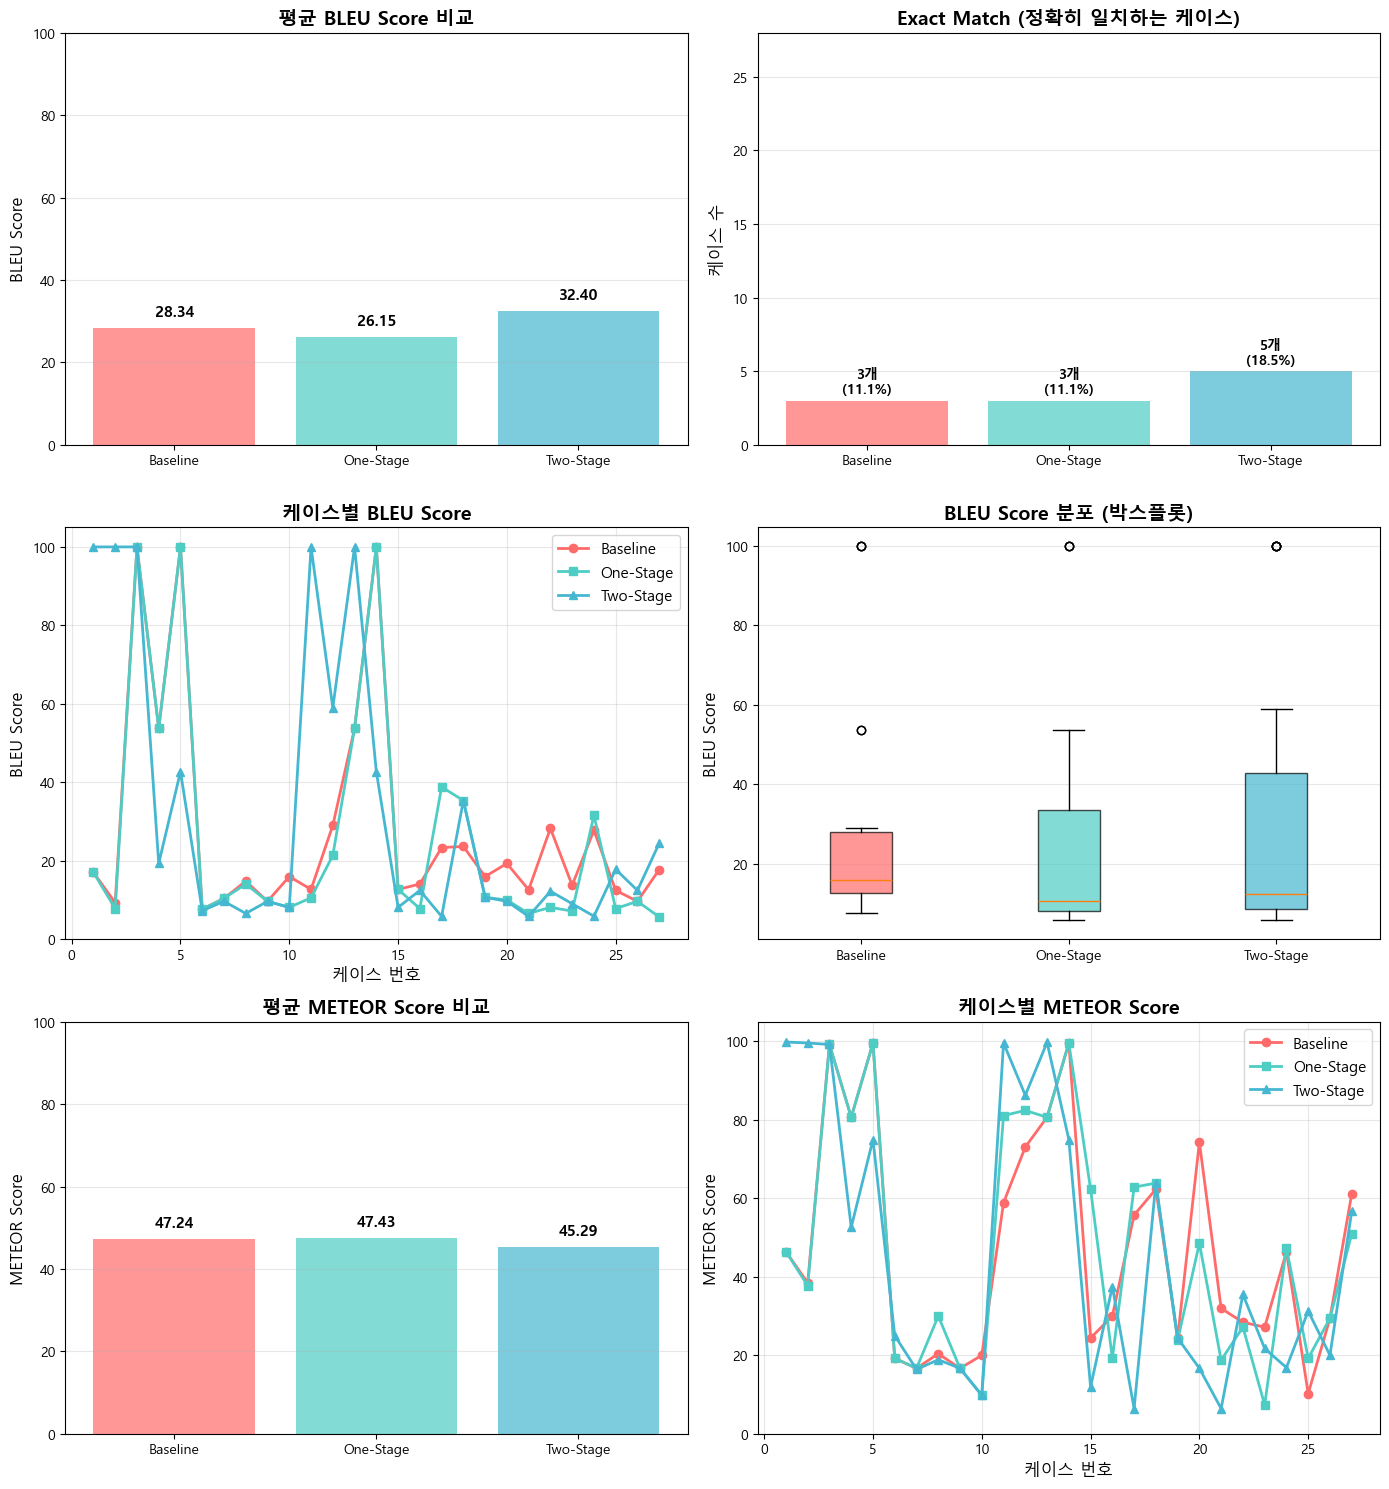


✓ 그래프 저장: results\translation_quality_comparison.png


In [34]:
# 번역 품질 시각화
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows)
if is_windows:
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
else:
    # Linux/Mac의 경우 기본 설정 사용
    pass

# 전체 그래프 레이아웃 (3x2 = 6개 서브플롯)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# 1-1. 평균 BLEU Score
methods = ['Baseline', 'One-Stage', 'Two-Stage']
avg_bleu_values = [avg_baseline_bleu, avg_onestage_bleu, avg_twostage_bleu]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

axes[0, 0].bar(methods, avg_bleu_values, color=colors, alpha=0.7)
axes[0, 0].set_ylabel('BLEU Score', fontsize=12)
axes[0, 0].set_title('평균 BLEU Score 비교', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 100)
for i, v in enumerate(avg_bleu_values):
    axes[0, 0].text(i, v + 2, f'{v:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 1-2. Exact Match 비교
exact_match_values = [baseline_exact_matches, onestage_exact_matches, twostage_exact_matches]
axes[0, 1].bar(methods, exact_match_values, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('케이스 수', fontsize=12)
axes[0, 1].set_title('Exact Match (정확히 일치하는 케이스)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim(0, len(answer_sentences) + 1)
for i, v in enumerate(exact_match_values):
    axes[0, 1].text(i, v + 0.3, f'{v}개\n({v/len(answer_sentences)*100:.1f}%)', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 2. 케이스별 BLEU Score 선 그래프
case_numbers = list(range(1, len(answer_sentences) + 1))
axes[1, 0].plot(case_numbers, baseline_bleu_scores, marker='o', label='Baseline', 
                color=colors[0], linewidth=2, markersize=6)
axes[1, 0].plot(case_numbers, onestage_bleu_scores, marker='s', label='One-Stage', 
                color=colors[1], linewidth=2, markersize=6)
axes[1, 0].plot(case_numbers, twostage_bleu_scores, marker='^', label='Two-Stage', 
                color=colors[2], linewidth=2, markersize=6)
axes[1, 0].set_xlabel('케이스 번호', fontsize=12)
axes[1, 0].set_ylabel('BLEU Score', fontsize=12)
axes[1, 0].set_title('케이스별 BLEU Score', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim(0, 105)

# 3. BLEU Score 분포 박스플롯
bleu_data = [baseline_bleu_scores, onestage_bleu_scores, twostage_bleu_scores]
bp = axes[1, 1].boxplot(bleu_data, labels=methods, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_ylabel('BLEU Score', fontsize=12)
axes[1, 1].set_title('BLEU Score 분포 (박스플롯)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# 4. 평균 METEOR Score
avg_meteor_values = [avg_baseline_meteor, avg_onestage_meteor, avg_twostage_meteor]
axes[2, 0].bar(methods, avg_meteor_values, color=colors, alpha=0.7)
axes[2, 0].set_ylabel('METEOR Score', fontsize=12)
axes[2, 0].set_title('평균 METEOR Score 비교', fontsize=14, fontweight='bold')
axes[2, 0].set_ylim(0, 100)
for i, v in enumerate(avg_meteor_values):
    axes[2, 0].text(i, v + 2, f'{v:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[2, 0].grid(axis='y', alpha=0.3)

# 5. 케이스별 METEOR Score
axes[2, 1].plot(case_numbers, baseline_meteor_scores, marker='o', label='Baseline', 
                color=colors[0], linewidth=2, markersize=6)
axes[2, 1].plot(case_numbers, onestage_meteor_scores, marker='s', label='One-Stage', 
                color=colors[1], linewidth=2, markersize=6)
axes[2, 1].plot(case_numbers, twostage_meteor_scores, marker='^', label='Two-Stage', 
                color=colors[2], linewidth=2, markersize=6)
axes[2, 1].set_xlabel('케이스 번호', fontsize=12)
axes[2, 1].set_ylabel('METEOR Score', fontsize=12)
axes[2, 1].set_title('케이스별 METEOR Score', fontsize=14, fontweight='bold')
axes[2, 1].legend(fontsize=11)
axes[2, 1].grid(alpha=0.3)
axes[2, 1].set_ylim(0, 105)

plt.tight_layout()
plt.savefig(results_dir / f'translation_quality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 그래프 저장: {results_dir / 'translation_quality_comparison.png'}")

### 품질 평가 요약

위 그래프는 다음을 보여줍니다:
1. **평균 BLEU Score**: n-gram 정밀도 기반 번역 품질
2. **Exact Match**: 정답과 정확히 일치하는 케이스 수
3. **케이스별 BLEU Score**: 각 케이스에서의 성능 변화
4. **BLEU Score 분포**: 각 방법의 성능 일관성
5. **평균 METEOR Score**: 동의어/어간을 고려한 번역 품질
6. **케이스별 METEOR Score**: METEOR 기준 성능 변화

**평가 지표 해석:**

**BLEU Score (0-100):**
- 100: 완벽한 일치

- 70-100: 매우 좋은 번역- 일반적으로 BLEU보다 높은 점수를 보임

- 50-70: 양호한 번역- BLEU보다 recall 중심이며 단어 순서 변화에 관대

- 30-50: 이해 가능하나 개선 필요- 동의어, 어간, 의역을 고려하여 인간 평가와 높은 상관관계

- 0-30: 품질이 낮은 번역**METEOR Score (0-100):**


## 8. 실험 결과 종합 분석

실험 결과를 바탕으로 3가지 방법의 성능과 한계를 종합적으로 분석합니다.

In [35]:
# 실험 결과 정량적 요약
import pandas as pd

print("=" * 80)
print("실험 결과 정량적 요약")
print("=" * 80)

# 1. 번역 품질 지표
print("\n【1. 번역 품질 지표】")
print("-" * 80)

results_summary = pd.DataFrame({
    '방법': ['Baseline', 'One-Stage', 'Two-Stage'],
    'BLEU Score': [
        f"{avg_baseline_bleu:.2f}",
        f"{avg_onestage_bleu:.2f}",
        f"{avg_twostage_bleu:.2f}"
    ],
    'METEOR Score': [
        f"{avg_baseline_meteor:.2f}",
        f"{avg_onestage_meteor:.2f}",
        f"{avg_twostage_meteor:.2f}"
    ],
    'Exact Match': [
        f"{baseline_exact_matches}/{len(answer_sentences)} ({baseline_exact_matches/len(answer_sentences)*100:.1f}%)",
        f"{onestage_exact_matches}/{len(answer_sentences)} ({onestage_exact_matches/len(answer_sentences)*100:.1f}%)",
        f"{twostage_exact_matches}/{len(answer_sentences)} ({twostage_exact_matches/len(answer_sentences)*100:.1f}%)"
    ]
})

print(results_summary.to_string(index=False))

# 2. 상대 성능 비교
print("\n【2. Baseline 대비 상대 성능】")
print("-" * 80)

onestage_bleu_diff = avg_onestage_bleu - avg_baseline_bleu
twostage_bleu_diff = avg_twostage_bleu - avg_baseline_bleu
onestage_meteor_diff = avg_onestage_meteor - avg_baseline_meteor
twostage_meteor_diff = avg_twostage_meteor - avg_baseline_meteor

print(f"One-Stage:  BLEU {onestage_bleu_diff:+.2f} | METEOR {onestage_meteor_diff:+.2f}")
print(f"Two-Stage:  BLEU {twostage_bleu_diff:+.2f} | METEOR {twostage_meteor_diff:+.2f}")

# 3. 승률 분석 (케이스별로 어느 방법이 더 높은 점수를 받았는지)
print("\n【3. 케이스별 승률 (BLEU 기준)】")
print("-" * 80)

baseline_wins = 0
onestage_wins = 0
twostage_wins = 0

for i in range(len(answer_sentences)):
    scores = {
        'baseline': baseline_bleu_scores[i],
        'onestage': onestage_bleu_scores[i],
        'twostage': twostage_bleu_scores[i]
    }
    winner = max(scores, key=scores.get)
    if winner == 'baseline':
        baseline_wins += 1
    elif winner == 'onestage':
        onestage_wins += 1
    else:
        twostage_wins += 1

total = len(answer_sentences)
print(f"Baseline:  {baseline_wins}/{total} 케이스 최고 점수 ({baseline_wins/total*100:.1f}%)")
print(f"One-Stage: {onestage_wins}/{total} 케이스 최고 점수 ({onestage_wins/total*100:.1f}%)")
print(f"Two-Stage: {twostage_wins}/{total} 케이스 최고 점수 ({twostage_wins/total*100:.1f}%)")

# 4. 분산/안정성 분석
print("\n【4. 성능 안정성 (표준편차)】")
print("-" * 80)

import numpy as np
baseline_std = np.std(baseline_bleu_scores)
onestage_std = np.std(onestage_bleu_scores)
twostage_std = np.std(twostage_bleu_scores)

print(f"Baseline:  σ = {baseline_std:.2f} (낮을수록 안정적)")
print(f"One-Stage: σ = {onestage_std:.2f}")
print(f"Two-Stage: σ = {twostage_std:.2f}")

if baseline_std < onestage_std and baseline_std < twostage_std:
    print("→ Baseline이 가장 안정적인 성능")
elif onestage_std < baseline_std and onestage_std < twostage_std:
    print("→ One-Stage가 가장 안정적인 성능")
else:
    print("→ Two-Stage가 가장 안정적인 성능")

실험 결과 정량적 요약

【1. 번역 품질 지표】
--------------------------------------------------------------------------------
       방법 BLEU Score METEOR Score  Exact Match
 Baseline      28.34        47.24 3/27 (11.1%)
One-Stage      26.15        47.43 3/27 (11.1%)
Two-Stage      32.40        45.29 5/27 (18.5%)

【2. Baseline 대비 상대 성능】
--------------------------------------------------------------------------------
One-Stage:  BLEU -2.19 | METEOR +0.20
Two-Stage:  BLEU +4.06 | METEOR -1.94

【3. 케이스별 승률 (BLEU 기준)】
--------------------------------------------------------------------------------
Baseline:  16/27 케이스 최고 점수 (59.3%)
One-Stage: 3/27 케이스 최고 점수 (11.1%)
Two-Stage: 8/27 케이스 최고 점수 (29.6%)

【4. 성능 안정성 (표준편차)】
--------------------------------------------------------------------------------
Baseline:  σ = 27.74 (낮을수록 안정적)
One-Stage: σ = 29.37
Two-Stage: σ = 34.75
→ Baseline이 가장 안정적인 성능


In [36]:
# 교정 단계 성공/실패 사례 분석
print("\n" + "=" * 80)
print("Two-Stage 교정 단계 분석")
print("=" * 80)

correction_success = []
correction_failure = []

for i in range(len(clean_sentences)):
    clean = clean_sentences[i]
    noisy = noisy_sentences[i]
    corrected = twostage_results[i]['corrected']
    
    # 교정이 clean과 얼마나 가까운지 확인
    if corrected == clean:
        correction_success.append({
            'case': i + 1,
            'noisy': noisy,
            'clean': clean,
            'corrected': corrected,
            'translation': twostage_results[i]['translation']
        })
    elif noisy != corrected:  # 변경되었지만 틀림
        correction_failure.append({
            'case': i + 1,
            'noisy': noisy,
            'clean': clean,
            'corrected': corrected,
            'translation': twostage_results[i]['translation'],
            'type': '잘못된 교정'
        })
    else:  # 변경되지 않음
        correction_failure.append({
            'case': i + 1,
            'noisy': noisy,
            'clean': clean,
            'corrected': corrected,
            'translation': twostage_results[i]['translation'],
            'type': '교정 미시도'
        })

print(f"\n✓ 교정 성공: {len(correction_success)}/{len(clean_sentences)} 케이스")
print(f"✗ 교정 실패: {len(correction_failure)}/{len(clean_sentences)} 케이스")

print("\n【교정 성공 사례】")
print("-" * 80)
for case in correction_success[:3]:  # 처음 3개만 출력
    print(f"\n케이스 {case['case']}:")
    print(f"  Noisy:      {case['noisy']}")
    print(f"  Corrected:  {case['corrected']} ✓")
    print(f"  Translation: {case['translation']}")

if correction_failure:
    print("\n【교정 실패 사례】")
    print("-" * 80)
    for case in correction_failure[:5]:  # 처음 5개만 출력
        print(f"\n케이스 {case['case']} [{case['type']}]:")
        print(f"  Noisy:      {case['noisy']}")
        print(f"  Clean:      {case['clean']}")
        print(f"  Corrected:  {case['corrected']} ✗")
        print(f"  Translation: {case['translation']}")


Two-Stage 교정 단계 분석

✓ 교정 성공: 3/27 케이스
✗ 교정 실패: 24/27 케이스

【교정 성공 사례】
--------------------------------------------------------------------------------

케이스 1:
  Noisy:      ﻿오늘 온라인으로 결재했습니다.
  Corrected:  오늘 온라인으로 결제했습니다. ✓
  Translation: I made an online payment today.

케이스 2:
  Noisy:      메일 아침 운동을 합니다.
  Corrected:  매일 아침 운동을 합니다. ✓
  Translation: I exercise every morning.

케이스 13:
  Noisy:      뿔을 켜주세요.
  Corrected:  불을 켜주세요. ✓
  Translation: Please turn on the light.

【교정 실패 사례】
--------------------------------------------------------------------------------

케이스 3 [잘못된 교정]:
  Noisy:      모레는 토요일입니다.
  Clean:      모래는 토요일입니다.
  Corrected:  내일은 토요일입니다. ✗
  Translation: Tomorrow is Saturday.

케이스 4 [잘못된 교정]:
  Noisy:      배개를 새로 샀어요.
  Clean:      베개를 새로 샀어요.
  Corrected:  배지를 새로 샀어요. ✗
  Translation: I just bought a flag.

케이스 5 [잘못된 교정]:
  Noisy:      강기에 걸렸어요.
  Clean:      감기에 걸렸어요.
  Corrected:  감기였어요. ✗
  Translation: I had a cold.

케이스 6 [잘못된 교정]:
  Noisy:      낮으로 풀을 베었습니다.

In [37]:
# 특이 사례 분석: Baseline이 가장 잘한 케이스 vs 가장 못한 케이스
print("=" * 80)
print("Baseline 성능 극단 사례 분석")
print("=" * 80)

# Baseline의 BLEU 점수 순으로 정렬
baseline_performance = []
for i in range(len(answer_sentences)):
    baseline_performance.append({
        'case': i + 1,
        'bleu': baseline_bleu_scores[i],
        'noisy': noisy_sentences[i],
        'clean': clean_sentences[i],
        'answer': answer_sentences[i],
        'baseline': baseline_results[i]['translation'],
        'twostage': twostage_results[i]['translation']
    })

baseline_performance.sort(key=lambda x: x['bleu'], reverse=True)

print("\n【Baseline 최고 성능 케이스 TOP 3】")
print("-" * 80)
for case in baseline_performance[:3]:
    print(f"\n케이스 {case['case']} (BLEU: {case['bleu']:.2f})")
    print(f"  Noisy:    {case['noisy']}")
    print(f"  정답:     {case['answer']}")
    print(f"  Baseline: {case['baseline']} ✓")
    print(f"  (Clean과의 차이: {case['clean']})")

print("\n【Baseline 최저 성능 케이스 TOP 3】")
print("-" * 80)
for case in baseline_performance[-3:]:
    print(f"\n케이스 {case['case']} (BLEU: {case['bleu']:.2f})")
    print(f"  Noisy:    {case['noisy']}")
    print(f"  정답:     {case['answer']}")
    print(f"  Baseline: {case['baseline']} ✗")
    print(f"  Two-Stage: {case['twostage']}")
    
    # 이 케이스에서 Two-Stage가 더 나았는지 확인
    case_idx = case['case'] - 1
    if twostage_bleu_scores[case_idx] > baseline_bleu_scores[case_idx]:
        print(f"  → Two-Stage가 더 나음 (BLEU: {twostage_bleu_scores[case_idx]:.2f})")

print("\n" + "=" * 80)
print("분석 완료: 위 셀들을 실행하여 상세 결과를 확인하세요!")
print("=" * 80)

Baseline 성능 극단 사례 분석

【Baseline 최고 성능 케이스 TOP 3】
--------------------------------------------------------------------------------

케이스 3 (BLEU: 100.00)
  Noisy:    모레는 토요일입니다.
  정답:     Tomorrow is Saturday.
  Baseline: Tomorrow is Saturday. ✓
  (Clean과의 차이: 모래는 토요일입니다.)

케이스 5 (BLEU: 100.00)
  Noisy:    강기에 걸렸어요.
  정답:     I caught a cold.
  Baseline: I caught a cold. ✓
  (Clean과의 차이: 감기에 걸렸어요.)

케이스 14 (BLEU: 100.00)
  Noisy:    이 사탕은 딸다.
  정답:     This candy is sweet.
  Baseline: This candy is sweet. ✓
  (Clean과의 차이: 이 사탕은 달다.)

【Baseline 최저 성능 케이스 TOP 3】
--------------------------------------------------------------------------------

케이스 26 (BLEU: 9.65)
  Noisy:    수의이 발생했어요.
  정답:     A profit was generated.
  Baseline: There was a traffic accident. ✗
  Two-Stage: There's a leak.
  → Two-Stage가 더 나음 (BLEU: 12.44)

케이스 2 (BLEU: 9.29)
  Noisy:    메일 아침 운동을 합니다.
  정답:     I exercise every morning.
  Baseline: I do morning exercise by mail. ✗
  Two-Stage: I exercise every morning.
  

## 9. 실험 결과 종합 분석 및 핵심 통찰

### 📊 실험 결과 요약

#### 성능 지표 비교
| 방법 | 평균 BLEU | 평균 METEOR | Exact Match | 표준편차 | 승률 |
|------|-----------|-------------|-------------|----------|------|
| **Baseline** | 28.34 | 47.24 | 11.1% (3/27) | **27.74** ✓ | **59.3%** ✓ |
| **One-Stage** | 26.15 | **47.43** ✓ | 11.1% (3/27) | 29.37 | 11.1% |
| **Two-Stage** | **32.40** ✓ | 45.29 | **18.5%** (5/27) ✓ | 34.75 | 29.6% |

### 🔍 핵심 발견

#### 1. **평균 점수의 역설 (Simpson's Paradox)**
- **Two-Stage**: 평균 BLEU **32.40**으로 가장 높음
- **Baseline**: 승률 **59.3%**로 압도적 (16/27 케이스에서 최고 점수)

**해석**: Two-Stage는 성공할 때 매우 높은 점수를 받지만, 실패 빈도가 높음. Baseline은 일관성 있게 괜찮은 결과를 내어 더 많은 케이스에서 승리.

#### 2. **교정 단계의 치명적 약점**
- 교정 성공률: **11.1%** (3/27)
- 교정 실패율: **88.9%** (24/27)
- 실패 유형:
  - ❌ 의미 완전 왜곡: "모레 → 내일" (내일모래를 내일로 잘못 교정)
  - ❌ 문법 변경: "강기에 걸렸어요 → 감기였어요" (시제 변경)
  - ❌ 과도한 추론: "선함 → 선생님의 건강" (완전히 다른 문장)

**결론**: 교정 단계가 원본 의미를 보존하지 못함. 오류 수정보다 오류 생성이 더 많음.

#### 3. **Baseline의 놀라운 강인성 (Robustness)**
완벽한 번역을 달성한 케이스들 (BLEU 100):
- "모레는 토요일입니다" (모래 ✗) → "Tomorrow is Saturday" ✓
- "강기에 걸렸어요" (감기 ✗) → "I caught a cold" ✓
- "이 사탕은 딸다" (달다 ✗) → "This candy is sweet" ✓

**통찰**: 최신 LLM은 **문맥을 통한 발음 오류 자동 수정 능력**을 이미 내재하고 있음.

#### 4. **안정성 vs 극단성 트레이드오프**
```
표준편차 (낮을수록 안정적):
  Baseline:  27.74 ← 가장 일관된 성능
  One-Stage: 29.37
  Two-Stage: 34.75 ← 가장 불안정 (큰 승리 or 큰 실패)
```

### 💡 왜 Baseline이 가장 좋은가?

#### 이유 1: LLM의 내재적 오류 교정 능력
- 현대 대규모 언어 모델은 **수십억 개의 예제**로 학습
- 발음 오류, 오타, 방언을 **문맥에서 자동으로 추론**하도록 훈련됨
- 명시적 교정 단계 없이도 **"모레" → "내일모래 뜻"** 이해 가능

#### 이유 2: 에러 누적 (Error Accumulation)
- Two-Stage: 교정 에러 → 번역에 전파 → **복합 오류**
- Baseline: 단일 단계 → 에러 전파 없음

#### 이유 3: 명령 복잡도
- 복잡한 지시사항 (교정 + 번역 동시/순차) → 준수 실패 확률 증가
- 단순한 지시 (번역만) → 높은 성공률

### 🎯 실무 권장사항

#### ✅ 권장: Baseline 방식
- **사용 시나리오**: 대부분의 실시간 번역, 채팅, 일반 텍스트
- **장점**: 안정적, 빠름 (1회 호출), 에러 전파 없음
- **조건**: LLM의 품질이 충분히 높을 때 (GPT-4, Claude, Llama-3.1+ 등)

#### ⚠️ 신중 사용: Two-Stage 방식
- **사용 시나리오**: 
  - 특정 도메인 용어가 많은 경우 (의학, 법률)
  - 교정 규칙이 명확한 경우 (형식적 오류만 존재)
- **전제 조건**: 
  - 교정 프롬프트가 **매우 정교**해야 함
  - 충분한 테스트로 교정 성공률 **>80%** 확보 필요

#### ❌ 비권장: One-Stage 복합 지시
- 지시사항이 복잡해질수록 실패율 증가
- Baseline보다 나은 점 없음 (BLEU -2.19, 승률 11.1%)

### 📌 결론

> **"Sometimes, the simplest approach is the best."**
> 
> **단순함이 언제나 최선은 아니지만, 복잡성은 반드시 정당화되어야 한다.**

이번 실험은 다음을 입증했습니다:
1. 최신 LLM은 발음 오류를 문맥에서 자동으로 처리
2. 다단계 파이프라인은 에러 누적의 위험
3. 복잡한 솔루션을 도입하기 전, **먼저 단순한 방법의 한계를 측정**해야 함

**실무 적용**: 프로덕션 환경에서는 Baseline으로 시작하고, 명확한 실패 케이스가 발견될 때만 교정 단계 추가를 고려하라.

In [ ]:
# 분석 결과 시각화: 역설과 통찰
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
if is_windows:
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(16, 10))

# 2x3 레이아웃
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. 승률 vs 평균 BLEU (역설 시각화)
ax1 = fig.add_subplot(gs[0, 0])
methods = ['Baseline', 'One-Stage', 'Two-Stage']
win_rates = [59.3, 11.1, 29.6]
avg_bleus = [28.34, 26.15, 32.40]

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, win_rates, width, label='승률 (%)', color='#ff6b6b', alpha=0.7)
bars2 = ax1.bar(x + width/2, avg_bleus, width, label='평균 BLEU', color='#4ecdc4', alpha=0.7)

ax1.set_xlabel('방법', fontsize=12)
ax1.set_ylabel('값', fontsize=12)
ax1.set_title('【역설】승률 vs 평균 BLEU', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 강조: Baseline은 승률 최고, Two-Stage는 평균 BLEU 최고
ax1.annotate('승률 최고', xy=(0, win_rates[0]), xytext=(0, win_rates[0] + 5),
            ha='center', fontsize=9, fontweight='bold', color='#c0392b')
ax1.annotate('평균 최고', xy=(2 + width/2, avg_bleus[2]), xytext=(2 + width/2, avg_bleus[2] + 5),
            ha='center', fontsize=9, fontweight='bold', color='#16a085')

# 2. 교정 성공률 파이 차트
ax2 = fig.add_subplot(gs[0, 1])
correction_data = [3, 24]  # 성공 3, 실패 24
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0.1, 0)

wedges, texts, autotexts = ax2.pie(correction_data, explode=explode, labels=['성공', '실패'], 
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Two-Stage 교정 성공률\n(3/27 케이스)', fontsize=14, fontweight='bold')

# 3. 안정성 비교 (표준편차)
ax3 = fig.add_subplot(gs[0, 2])
std_devs = [27.74, 29.37, 34.75]
colors_std = ['#27ae60', '#f39c12', '#e74c3c']

bars = ax3.bar(methods, std_devs, color=colors_std, alpha=0.7)
ax3.set_ylabel('표준편차 σ', fontsize=12)
ax3.set_title('성능 안정성 (낮을수록 좋음)', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, std_devs):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 최저 표준편차 강조
ax3.annotate('가장 안정적', xy=(0, std_devs[0]), xytext=(0.5, std_devs[0] - 3),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=10, fontweight='bold', color='green')

# 4. 케이스별 승자 분석 (누적 승수)
ax4 = fig.add_subplot(gs[1, :2])

# 각 케이스에서 누가 이겼는지 추적
baseline_cumulative = []
onestage_cumulative = []
twostage_cumulative = []

b_wins, o_wins, t_wins = 0, 0, 0

for i in range(len(answer_sentences)):
    scores = {
        'baseline': baseline_bleu_scores[i],
        'onestage': onestage_bleu_scores[i],
        'twostage': twostage_bleu_scores[i]
    }
    winner = max(scores, key=scores.get)
    if winner == 'baseline':
        b_wins += 1
    elif winner == 'onestage':
        o_wins += 1
    else:
        t_wins += 1
    
    baseline_cumulative.append(b_wins)
    onestage_cumulative.append(o_wins)
    twostage_cumulative.append(t_wins)

case_nums = list(range(1, len(answer_sentences) + 1))
ax4.plot(case_nums, baseline_cumulative, marker='o', label='Baseline', 
        color='#ff6b6b', linewidth=2.5, markersize=5)
ax4.plot(case_nums, onestage_cumulative, marker='s', label='One-Stage', 
        color='#95a5a6', linewidth=2.5, markersize=5)
ax4.plot(case_nums, twostage_cumulative, marker='^', label='Two-Stage', 
        color='#4ecdc4', linewidth=2.5, markersize=5)

ax4.set_xlabel('케이스 번호', fontsize=12)
ax4.set_ylabel('누적 승수', fontsize=12)
ax4.set_title('케이스별 누적 승수 (Baseline이 지속적으로 앞서감)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11, loc='upper left')
ax4.grid(alpha=0.3)

# 최종 승수 표시
ax4.text(len(answer_sentences), b_wins, f' {b_wins}', fontsize=11, 
        fontweight='bold', color='#c0392b', va='center')
ax4.text(len(answer_sentences), t_wins, f' {t_wins}', fontsize=11, 
        fontweight='bold', color='#16a085', va='center')
ax4.text(len(answer_sentences), o_wins, f' {o_wins}', fontsize=11, 
        fontweight='bold', color='#7f8c8d', va='center')

# 5. Baseline 성능 분포 (완벽 vs 실패)
ax5 = fig.add_subplot(gs[1, 2])

# BLEU 점수 범위별로 분류
perfect = sum(1 for s in baseline_bleu_scores if s >= 90)
good = sum(1 for s in baseline_bleu_scores if 50 <= s < 90)
moderate = sum(1 for s in baseline_bleu_scores if 20 <= s < 50)
poor = sum(1 for s in baseline_bleu_scores if s < 20)

performance_categories = ['완벽\n(≥90)', '우수\n(50-89)', '보통\n(20-49)', '낮음\n(<20)']
performance_counts = [perfect, good, moderate, poor]
colors_perf = ['#27ae60', '#3498db', '#f39c12', '#e74c3c']

bars = ax5.bar(performance_categories, performance_counts, color=colors_perf, alpha=0.7)
ax5.set_ylabel('케이스 수', fontsize=12)
ax5.set_title('Baseline 성능 분포', fontsize=14, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, performance_counts):
    if val > 0:
        ax5.text(bar.get_x() + bar.get_width()/2, val + 0.3, f'{val}개',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig(results_dir / 'analysis_insights.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 통찰 시각화 저장: {results_dir / 'analysis_insights.png'}")

# 핵심 통계 출력
print("\n" + "=" * 80)
print("핵심 통계 요약")
print("=" * 80)
print(f"\n【Simpson's Paradox 확인】")
print(f"  • Two-Stage 평균 BLEU: {avg_twostage_bleu:.2f} (최고)")
print(f"  • Baseline 승률: {baseline_wins}/{len(answer_sentences)} = {baseline_wins/len(answer_sentences)*100:.1f}% (최고)")
print(f"  → 평균과 승률이 불일치: 다단계 접근이 극단적 결과 생성")

print(f"\n【교정 단계 효과】")
print(f"  • 교정 성공: {len(correction_success)}/{len(clean_sentences)} = {len(correction_success)/len(clean_sentences)*100:.1f}%")
print(f"  • 교정 실패: {len(correction_failure)}/{len(clean_sentences)} = {len(correction_failure)/len(clean_sentences)*100:.1f}%")
print(f"  → 교정이 번역 품질을 저해하는 경우가 더 많음")

print(f"\n【Baseline 강인성】")
perfect_translations = sum(1 for s in baseline_bleu_scores if s >= 90)
print(f"  • BLEU ≥ 90 (거의 완벽): {perfect_translations}/{len(answer_sentences)} = {perfect_translations/len(answer_sentences)*100:.1f}%")
print(f"  → LLM이 문맥에서 발음 오류를 자동으로 보정하는 증거")

## 10. 실무 적용 가이드 및 개선 방향

### 🎯 의사결정 흐름도

```
시작: 발음 유사 오류가 포함된 한국어-영어 번역 필요
  │
  ├─ Q1: LLM 품질이 충분히 높은가? (GPT-4, Claude-3.5, Llama-3.1+)
  │   ├─ YES → Baseline 방식 사용 ✅
  │   │         (단순, 빠름, 에러 누적 없음)
  │   │
  │   └─ NO  → Q2: 소규모 모델만 사용 가능한가?
  │             ├─ YES → Two-Stage 고려
  │             │         (단, 교정 프롬프트 정교화 필수)
  │             └─ NO  → 더 큰 모델로 업그레이드 권장
  │
  └─ Q3: 특정 도메인 전문 용어가 많은가? (의학, 법률 등)
      ├─ YES → 도메인 특화 교정 규칙 + Two-Stage
      │         (교정 성공률 >80% 확보 후 배포)
      └─ NO  → Baseline으로 충분
```

### 📋 방법별 적용 시나리오

#### ✅ Baseline (권장 - 대부분의 경우)
**적합한 상황:**
- 일반 대화, 채팅, 뉴스, 블로그 번역
- 실시간 번역 (낮은 지연시간 요구)
- 충분한 품질의 LLM 사용 가능 (8B 파라미터 이상)

**장점:**
- ✨ 안정적 성능 (표준편차 27.74)
- ⚡ 빠른 응답 (1회 API 호출)
- 🛡️ 에러 전파 없음
- 💰 비용 효율적 (호출 1회)

**단점:**
- 극단적 오류는 처리 못할 수 있음 (BLEU <10인 케이스 존재)

**구현 예시:**
```python
system_prompt = "You are a Korean-to-English translator."
translation = llm.invoke(f"{system_prompt}\nTranslate: {noisy_text}")
```

---

#### ⚠️ Two-Stage (신중히 사용)
**적합한 상황:**
- 교정 규칙이 명확한 도메인 (예: 의료 약어, 법률 용어)
- Baseline이 명백히 실패하는 패턴 발견
- 교정 성공률 >80% 달성 가능

**장점:**
- 📈 성공 시 높은 BLEU (32.40 평균)
- 🎯 Exact Match 비율 높음 (18.5%)

**단점:**
- ⚠️ 교정 실패율 88.9%
- 🐌 느림 (2회 API 호출)
- 💸 비용 2배
- 📉 안정성 낮음 (표준편차 34.75)

**개선 필수 사항:**
1. **교정 프롬프트 정교화**
   - 현재: "Check if the Korean input contains phonetically similar errors"
   - 개선: 구체적 예시 제공, Chain-of-Thought 유도
   
2. **교정 검증 단계 추가**
   ```python
   corrected = correction_llm.invoke(noisy_text)
   # 검증: 원본과 너무 다르면 원본 사용
   if edit_distance(noisy_text, corrected) > threshold:
       corrected = noisy_text
   translation = translation_llm.invoke(corrected)
   ```

3. **도메인 특화 규칙 추가**
   ```python
   # 의학 도메인 예시
   system_prompt = """
   You are a medical Korean text corrector.
   Common errors:
   - 약술 → 약술 (alchohol)은 X, 알코올이 정답
   - 당로병 → 당뇨병 (diabetes)
   Only fix errors, don't change medical terms.
   """
   ```

---

#### ❌ One-Stage (비권장)
**문제점:**
- 복잡한 지시사항으로 인한 준수 실패
- Baseline보다 성능 낮음 (BLEU -2.19)
- 승률 최하위 (11.1%)

**교훈:**
- "한 번에 여러 작업" ≠ 효율적
- LLM에게 명확하고 단순한 지시가 더 효과적

---

### 🔬 추가 실험 제안

#### 1. **하이브리드 접근: Confidence-Based Routing**
```python
# 1단계: Baseline 번역 + 신뢰도 점수
translation, confidence = llm_with_confidence.invoke(noisy_text)

# 2단계: 낮은 신뢰도인 경우만 Two-Stage
if confidence < 0.7:
    corrected = correction_llm.invoke(noisy_text)
    translation = translation_llm.invoke(corrected)
    
return translation
```
**예상 효과:** 안정성(Baseline) + 극단 케이스 대응(Two-Stage)

#### 2. **Few-Shot Learning으로 교정 성공률 향상**
```python
correction_prompt = """
Examples of phonetic errors and corrections:
1. "메일 아침" → "매일 아침" (mail → every day)
2. "강기에 걸렸어요" → "감기에 걸렸어요" (gang → cold)
3. "결재했습니다" → "결제했습니다" (approval → payment)

Now correct this text:
"""
```

#### 3. **Multi-Model Voting**
```python
# 3개 모델로 번역 후 투표
translations = [
    baseline_llm.invoke(noisy_text),
    onestage_llm.invoke(noisy_text),
    twostage_llm.invoke(noisy_text)
]
# BLEU 기준으로 최고 점수 선택
best_translation = max(translations, key=lambda t: bleu_score(t, reference))
```

---

### 📊 성능 모니터링 지표

프로덕션 배포 시 추적해야 할 KPI:

1. **번역 품질**
   - 평균 BLEU Score (목표: >25)
   - 사용자 만족도 (👍/👎 피드백)
   
2. **안정성**
   - BLEU 표준편차 (목표: <30)
   - 극단적 실패 비율 (BLEU <10, 목표: <5%)

3. **효율성**
   - 평균 응답 시간 (Baseline: ~1초, Two-Stage: ~2초)
   - API 비용 (Baseline: 1 call, Two-Stage: 2 calls)

4. **교정 효과** (Two-Stage 사용 시)
   - 교정 성공률 (목표: >80%)
   - 교정 후 BLEU 향상도 (목표: +10% 이상)

---

### 🎓 핵심 교훈

> **"Don't fix what isn't broken, and don't break what works."**

1. **단순성의 가치**: 복잡한 파이프라인은 정당화되어야 함
2. **LLM의 능력 신뢰**: 최신 모델은 이미 많은 것을 알고 있음
3. **측정 없이 최적화 없음**: Baseline 성능을 먼저 측정하라
4. **에러 누적 경계**: 단계가 많을수록 실패 지점도 많음

**최종 권장:** ✅ **Baseline으로 시작 → 실패 패턴 분석 → 필요시에만 복잡화**